In [1]:
import re
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import IFrame
import matplotlib.font_manager as fm

plt.style.use('ggplot')
%matplotlib inline
pd.options.display.max_columns=25

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Pulling the data

I will begin by pulling all the shot data from a single game. Below, in the url, one can see I have set the GameID=0021500051 (GSW vs. MEM on Nov. 2, 2015) and the TeamID=1610612744 (GSW). I will use requests library to get the the data from the url.

In [2]:
url = 'http://stats.nba.com/stats/shotchartdetail?'\
        'CFID=&CFPARAMS=&ContextFilter=&ContextMeasure=FGA'\
        '&Counter=1000&DateFrom=&DateTo=&Direction=DESC'\
        '&GameID=0021500051&GameSegment=&LastNGames=0&LeagueID=00'\
        '&Location=&Month=0&OpponentTeamID=0&Outcome=&Period=0'\
        '&PlayerID=0&PlayerOrTeam=T&Position=&RookieYear='\
        '&Season=2015-16&SeasonSegment=&SeasonType=Regular+Season'\
        '&Sorter=PTS&TeamID=1610612744&VsConference=&VsDivision='
response = requests.get(url)
response.json().keys()

[u'resource', u'resultSets', u'parameters']

This is similar to most returned jsons from stats.nba.com. The resource is the name of the resource I am accessing. In this case, it will be 'shotchartdetail'. The resultSets are the values that are returned to me containing the data I requested. The parameters are the relevant parameters issued for this request. Later in this notebook, I will make a request using these parameters in a dict and passing them as an argument in request.get().

Below I explore the keys returned and the relevant information.

In [3]:
resource = response.json()["resource"]
resultSets = response.json()["resultSets"]
parameters = response.json()["parameters"]
print resource
parameters

shotchartdetail


{u'AheadBehind': None,
 u'ClutchTime': None,
 u'ContextFilter': u'',
 u'ContextMeasure': u'FGA',
 u'DateFrom': None,
 u'DateTo': None,
 u'EndPeriod': None,
 u'EndRange': None,
 u'GameID': u'0021500051',
 u'GameSegment': None,
 u'LastNGames': 0,
 u'LeagueID': u'00',
 u'Location': None,
 u'Month': 0,
 u'OpponentTeamID': 0,
 u'Outcome': None,
 u'Period': 0,
 u'PlayerID': 0,
 u'PointDiff': None,
 u'Position': None,
 u'RangeType': None,
 u'RookieYear': None,
 u'Season': u'2015-16',
 u'SeasonSegment': None,
 u'SeasonType': u'Regular Season',
 u'StartPeriod': None,
 u'StartRange': None,
 u'TeamID': 1610612744,
 u'VsConference': None,
 u'VsDivision': None}

In [4]:
print type(resultSets)

<type 'list'>


In [5]:
print len(resultSets)

2


In [6]:
print [type(r) for r in resultSets]

[<type 'dict'>, <type 'dict'>]


In [7]:
print [r.keys() for r in resultSets]

[[u'headers', u'rowSet', u'name'], [u'headers', u'rowSet', u'name']]


In [8]:
[r['name'] for r in resultSets]

[u'Shot_Chart_Detail', u'LeagueAverages']

Great! This is like most resultSets returned from the stats.nba.com, where the first dict is the data on the player or team, and the second dict contains the league averages. Very useful!

Let's see what kind of data lies within 'Shot_Chart_Detail': 

In [9]:
resultSets[0]['headers']

[u'GRID_TYPE',
 u'GAME_ID',
 u'GAME_EVENT_ID',
 u'PLAYER_ID',
 u'PLAYER_NAME',
 u'TEAM_ID',
 u'TEAM_NAME',
 u'PERIOD',
 u'MINUTES_REMAINING',
 u'SECONDS_REMAINING',
 u'EVENT_TYPE',
 u'ACTION_TYPE',
 u'SHOT_TYPE',
 u'SHOT_ZONE_BASIC',
 u'SHOT_ZONE_AREA',
 u'SHOT_ZONE_RANGE',
 u'SHOT_DISTANCE',
 u'LOC_X',
 u'LOC_Y',
 u'SHOT_ATTEMPTED_FLAG',
 u'SHOT_MADE_FLAG']

In [10]:
resultSets[0]['rowSet'][0]

[u'Shot Chart Detail',
 u'0021500051',
 4,
 203084,
 u'Harrison Barnes',
 1610612744,
 u'Golden State Warriors',
 1,
 11,
 27,
 u'Missed Shot',
 u'Turnaround Jump Shot',
 u'2PT Field Goal',
 u'Mid-Range',
 u'Left Side(L)',
 u'8-16 ft.',
 11,
 -110,
 46,
 1,
 0]

Let's load the `resultSets[0]` into a dataframe using the header for column labels

In [11]:
sc_df = pd.DataFrame(resultSets[0]['rowSet'],columns=resultSets[0]['headers'])
sc_df.head(8)

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,Shot Chart Detail,0021500051,4,203084,Harrison Barnes,1610612744,Golden State Warriors,1,11,27,Missed Shot,Turnaround Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,11,-110,46,1,0
1,Shot Chart Detail,0021500051,11,201939,Stephen Curry,1610612744,Golden State Warriors,1,10,36,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,28,-210,188,1,1
2,Shot Chart Detail,0021500051,13,203110,Draymond Green,1610612744,Golden State Warriors,1,10,5,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-173,203,1,1
3,Shot Chart Detail,0021500051,17,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,34,Made Shot,Running Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,20,-160,120,1,1
4,Shot Chart Detail,0021500051,26,203084,Harrison Barnes,1610612744,Golden State Warriors,1,8,35,Missed Shot,Turnaround Jump Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,3,22,26,1,0
5,Shot Chart Detail,0021500051,29,201939,Stephen Curry,1610612744,Golden State Warriors,1,8,5,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,24,-20,247,1,0
6,Shot Chart Detail,0021500051,38,202691,Klay Thompson,1610612744,Golden State Warriors,1,7,25,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,21,86,193,1,1
7,Shot Chart Detail,0021500051,43,202691,Klay Thompson,1610612744,Golden State Warriors,1,6,47,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,16,161,21,1,1


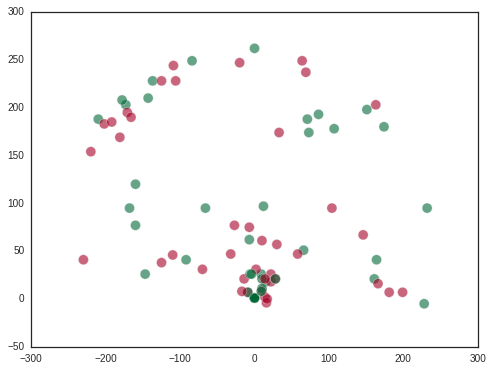

In [12]:
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(8, 6))
scat = plt.scatter(x=sc_df.LOC_X,y=sc_df.LOC_Y,c=sc_df.SHOT_MADE_FLAG,
    cmap=plt.cm.RdYlGn, s=100, alpha=.6)
plt.show()

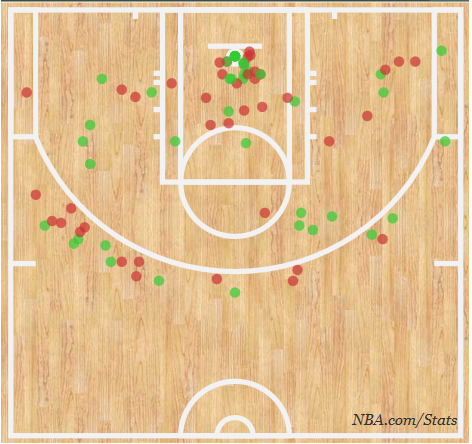

In [13]:
from IPython.display import Image
Image('img/example_nba_shotchart.png')

Okay, so we can see that the court is flipped on the NBA website. So I will flip my y-axis

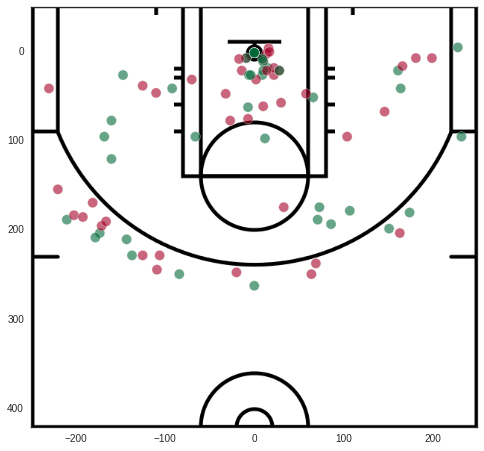

In [14]:
plt.style.use('seaborn-white')

fig,ax = plt.subplots(figsize=(8, 8))
scat = plt.scatter(x=sc_df.LOC_X,y=sc_df.LOC_Y,c=sc_df.SHOT_MADE_FLAG,
    cmap=plt.cm.RdYlGn, s=100, alpha=.6, zorder=1)
ax.invert_yaxis()

plt.style.use('grayscale')
#Read in the half court image
court = plt.imread("img/halfcourt.png")
#The baseline is 4 ft. from front of backboard. front of backboard is 15 in. from center of hoop (the origin).
#Therefore, my image extent needs to go from (4ft.+15in.) = 5.25 ft. so 52.5 ft. in the coordinate system.
img = plt.imshow(court, zorder=0, extent=[-250,250,420,-52.5])

plt.show()

Great, I can make sense and plot the data from nba.com.  Now I will get shot data for all players for the 2015-16 season and determine the best shooter from each zone.

Steps
1. Pull shot data for all players
2. Parse the data into a table with rows of players, columns of zone1_attempts zone1_made, etc.
3. Calculate best for each zone

Below, I expose a bit more about the nba stats API. I setup a dict of the required parameters to the shotchartdetail call. I set TeamID, GameID, and PlayerID to 0. With Season set to 2015-16, I will pull all the shot data for the regular season so far. Initially, I was going to pull each player with separate calls, but this is much better (and makes a lot fewer requests for the site).

In [15]:
sc_params = {u'AheadBehind': u'',
 u'ClutchTime': u'',
 u'ContextFilter': u'',
 u'ContextMeasure': u'FGA',
 u'DateFrom': u'',
 u'DateTo': u'',
 u'EndPeriod': u'',
 u'EndRange': u'',
 u'GameID': u'',
 u'GameSegment': u'',
 u'LastNGames': 0,
 u'LeagueID': u'00',
 u'Location': u'',
 u'Month': 0,
 u'OpponentTeamID': 0,
 u'Outcome': u'',
 u'Period': 0,
 u'PlayerID': 0,
 u'PointDiff': u'',
 u'Position': u'',
 u'RangeType': u'',
 u'RookieYear': u'',
 u'Season': u'2015-16',
 u'SeasonSegment': u'',
 u'SeasonType': u'Regular Season',
 u'StartPeriod': u'',
 u'StartRange': u'',
 u'TeamID': 0,
 u'VsConference': u'',
 u'VsDivision': u''}

baseurl = 'http://stats.nba.com/stats/shotchartdetail?'
resp2 = requests.get(baseurl,params=sc_params)
print resp2.url
print resp2.json().keys()

http://stats.nba.com/stats/shotchartdetail?PlayerID=0&StartPeriod=&StartRange=&TeamID=0&VsConference=&Location=&SeasonType=Regular+Season&RangeType=&RookieYear=&Season=2015-16&DateFrom=&ClutchTime=&EndPeriod=&EndRange=&ContextFilter=&GameID=&OpponentTeamID=0&DateTo=&GameSegment=&AheadBehind=&PointDiff=&LastNGames=0&VsDivision=&LeagueID=00&Position=&Outcome=&ContextMeasure=FGA&SeasonSegment=&Period=0&Month=0
[u'resource', u'resultSets', u'parameters']


In [17]:
player_shot_df = pd.DataFrame(resp2.json()['resultSets'][0]['rowSet'],columns=resp2.json()['resultSets'][0]['headers'])
print player_shot_df.shape
player_shot_df.head(5)

(19583, 21)


,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,Shot Chart Detail,0021500001,2,203083,Andre Drummond,1610612765,Detroit Pistons,1,11,41,Missed Shot,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,-17,-6,1,0
1,Shot Chart Detail,0021500001,5,202694,Marcus Morris,1610612765,Detroit Pistons,1,11,21,Made Shot,Step Back Jump shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,13,117,67,1,1
2,Shot Chart Detail,0021500001,6,200794,Paul Millsap,1610612737,Atlanta Hawks,1,11,0,Made Shot,Step Back Jump shot,2PT Field Goal,In The Paint (Non-RA),Right Side(R),8-16 ft.,12,76,95,1,1
3,Shot Chart Detail,0021500001,7,203484,Kentavious Caldwell-Pope,1610612765,Detroit Pistons,1,10,44,Made Shot,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Left Side(L),8-16 ft.,8,-68,51,1,1
4,Shot Chart Detail,0021500001,8,201143,Al Horford,1610612737,Atlanta Hawks,1,10,27,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,20,-117,164,1,0


### Plot all the shots

Now, I will plot all of the shots so far this season. I changed the court to be black and used the plasma colormap so that the made shots stand out more than the misses.

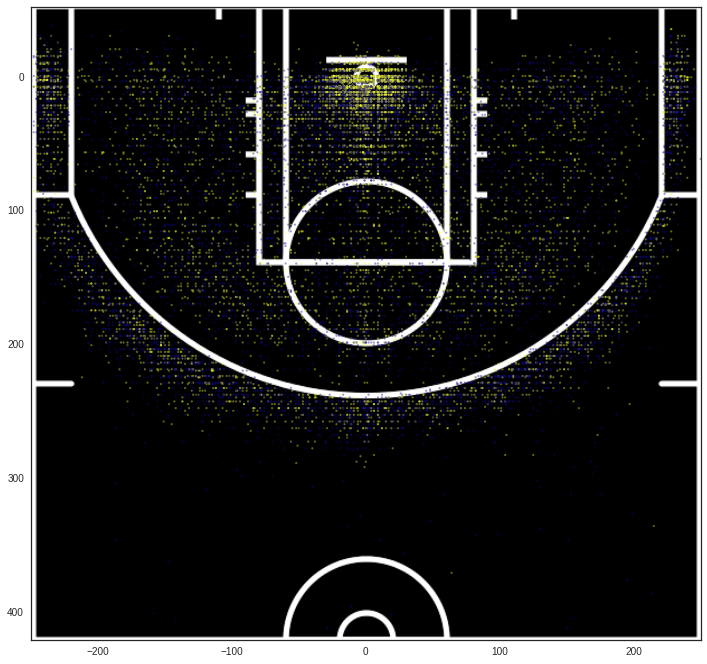

In [18]:
plt.style.use('seaborn-white')

fig,ax = plt.subplots(figsize=(12, 12))
scat = plt.scatter(x=player_shot_df.LOC_X,y=player_shot_df.LOC_Y,c=player_shot_df.SHOT_MADE_FLAG,
    cmap=plt.cm.plasma, s=5, alpha=.4, edgecolors='none', zorder=1)
ax.invert_yaxis()

#Read in the half court image
court = plt.imread("img/halfcourt.png")
#The baseline is 4 ft. from front of backboard. front of backboard is 15 in. from center of hoop (the origin).
#Therefore, my image extent needs to go from (4ft.+15in.) = 5.25 ft. so 52.5 ft. in the coordinate system.
img = plt.imshow(court, zorder=0, extent=[-250,250,420,-52.5])

plt.show()

Close enough. The out-of-bounds lines are actually inside the bounds of the court. I can work on drawing the court very carefully in another notebook.

Here is a summary of shot types (2pt,3pt), shot zone areas (L,LC,C,RC,L), and shot zone ranges (<8,8-16,16-24,>24)

In [19]:
keepfields=['SHOT_TYPE','SHOT_ZONE_AREA','SHOT_ZONE_RANGE','SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG']
shot_type_zone_df = player_shot_df[keepfields].groupby(['SHOT_TYPE','SHOT_ZONE_AREA']).sum()
shot_type_zone_df = shot_type_zone_df.assign(FG_PCT = shot_type_zone_df['SHOT_MADE_FLAG']/shot_type_zone_df['SHOT_ATTEMPTED_FLAG'])
shot_type_zone_df

SHOT_ATTEMPTED_FLAG  SHOT_MADE_FLAG  \
SHOT_TYPE      SHOT_ZONE_AREA                                               
2PT Field Goal Back Court(BC)                           1               0   
               Center(C)                             9794            5130   
               Left Side Center(LC)                   804             321   
               Left Side(L)                          1496             579   
               Right Side Center(RC)                  775             291   
               Right Side(R)                         1338             502   
3PT Field Goal Back Court(BC)                          49               1   
               Center(C)                             1002             329   
               Left Side Center(LC)                  1554             525   
               Left Side(L)                           728             288   
               Right Side Center(RC)                 1409             460   
               Right Side(R)                          633             213   

                                        FG_PCT  
SHOT_TYPE      SHOT_ZONE_AREA                   
2PT Field Goal Back Court(BC)         0.000000  
               Center(C)              0.523790  
               Left Side Center(LC)   0.399254  
               Left Side(L)           0.387032  
               Right Side Center(RC)  0.375484  
               Right Side(R)          0.375187  
3PT Field Goal Back Court(BC)         0.020408  
               Center(C)              0.328343  
               Left Side Center(LC)   0.337838  
               Left Side(L)           0.395604  
               Right Side Center(RC)  0.326473  
               Right Side(R)          0.336493

Hmm. A 2 PT back court shot? I can't think of a scenario where that could occur.
I will investigate and clean this up.

In [21]:
bad_code = player_shot_df[(player_shot_df['SHOT_TYPE']=='2PT Field Goal') & (player_shot_df['SHOT_ZONE_AREA']=='Back Court(BC)')]
bad_code

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
2807,Shot Chart Detail,0021500017,165,201937,Ricky Rubio,1610612750,Minnesota Timberwolves,2,8,34,Missed Shot,Jump Shot,2PT Field Goal,Backcourt,Back Court(BC),Back Court Shot,75,60,748,1,0


In [22]:
#It is clearly a 3PT shot (based on distance, x, and y)
player_shot_df.loc[2807,'SHOT_TYPE']='3PT Field Goal'
#See if any shots with distance > 24 ft. are marked as 2 PT
player_shot_df[(player_shot_df['SHOT_TYPE']=='2PT Field Goal') & (player_shot_df['SHOT_DISTANCE']>=24)]

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG


I will examine some other fields to make sure things are in order.

In [23]:
player_shot_df['ACTION_TYPE'].value_counts()

Jump Shot                             9631
Layup Shot                            1850
Driving Layup Shot                    1155
Pullup Jump shot                       982
Floating Jump shot                     482
Hook Shot                              408
Step Back Jump shot                    398
Tip Layup Shot                         383
Running Layup Shot                     348
Turnaround Jump Shot                   324
Dunk Shot                              308
Cutting Layup Shot                     292
Running Jump Shot                      271
Fadeaway Jump Shot                     230
Putback Layup Shot                     208
Reverse Layup Shot                     200
Driving Finger Roll Layup Shot         199
Jump Bank Shot                         162
Turnaround Hook Shot                   155
Driving Floating Jump Shot             137
Driving Reverse Layup Shot             128
Cutting Dunk Shot                      122
Running Dunk Shot                      118
Driving Dun

What a mess! Just some of the issues here:
* seems to be a lot of 'Driving' and 'Running' shots with very little difference between them
* 'No Shot' shots? That can't be correct
* [sS]hot needs to be standardized
* Some descriptives seem very subjective

Use some regex to clean it up and see the proportions of each action type

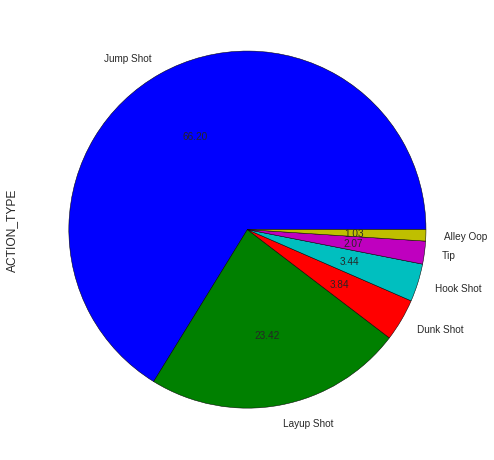

In [25]:
import re
def clean_action_type(text):
    text=re.sub(u'shot',u'Shot',text)
    text=re.sub(u'Driving |Running |Cutting ',u'',text)
    text=re.sub(u'Pullup |Pull-Up |Step Back |Turnaround |Putback |Floating |Finger Roll |Reverse ',u'',text)
    text=re.sub(u'Tip Layup Shot|Tip Dunk Shot',u'Tip',text)
    text=re.sub(u'Alley Oop Dunk Shot|Alley Oop Layup Shot',u'Alley Oop',text)
    text=re.sub(u'Fadeaway Shot|Fadeaway Bank Shot|Fadeaway Bank Jump Shot',u'Fadeaway Jump Shot',text)
    text=re.sub(u'Bank Jump Shot|Jump Bank Shot|Bank Shot|Fadeaway Jump Shot',u'Jump Shot',text)
    text=re.sub(u'Bank Hook Shot|Hook Bank Shot|Hook Jump Shot',u'Hook Shot',text)
    return text

action_counts = player_shot_df['ACTION_TYPE'].map(lambda x: clean_action_type(x)).value_counts()

action_counts.drop('No Shot').plot(kind='pie',figsize=(8,8),autopct='%.2f',colors=['b','g','r','c','m','y','gray','orange'])

Unsurprisingly, jump shots are most common.

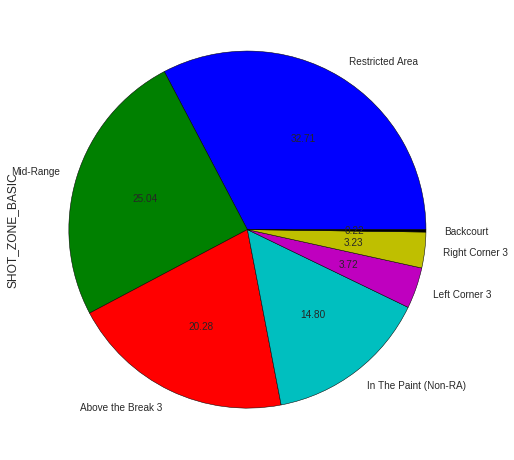

In [26]:
player_shot_df['SHOT_ZONE_BASIC'].value_counts().plot(kind='pie',figsize=(8,8),autopct='%.2f')

### No shot
To see what is going on with the 'No Shot' action types, I will filter the data frame.

In [27]:
player_shot_df[player_shot_df['ACTION_TYPE']=='No Shot']

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
17582,Shot Chart Detail,0021500104,34,203105,Festus Ezeli,1610612744,Golden State Warriors,1,6,51,Made Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,1,1,1
17584,Shot Chart Detail,0021500104,37,202704,Reggie Jackson,1610612765,Detroit Pistons,1,6,23,Made Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,10,7,1,1
17592,Shot Chart Detail,0021500104,59,101106,Andrew Bogut,1610612744,Golden State Warriors,1,4,16,Missed Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,-7,21,1,0
17593,Shot Chart Detail,0021500104,61,101106,Andrew Bogut,1610612744,Golden State Warriors,1,4,14,Made Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-4,7,1,1
17617,Shot Chart Detail,0021500104,135,2733,Shaun Livingston,1610612744,Golden State Warriors,2,8,35,Missed Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-9,2,1,0
17627,Shot Chart Detail,0021500104,168,201578,Marreese Speights,1610612744,Golden State Warriors,2,6,23,Missed Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,6,13,1,0
17629,Shot Chart Detail,0021500104,173,203382,Aron Baynes,1610612765,Detroit Pistons,2,6,10,Missed Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,3,0,1,0
17693,Shot Chart Detail,0021500104,351,101106,Andrew Bogut,1610612744,Golden State Warriors,3,1,50,Missed Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,1,4,1,0
17694,Shot Chart Detail,0021500104,353,101106,Andrew Bogut,1610612744,Golden State Warriors,3,1,49,Made Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,1,7,1,1
17698,Shot Chart Detail,0021500104,367,101106,Andrew Bogut,1610612744,Golden State Warriors,3,0,48,Made Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,-11,16,1,1


These are games from the same recent night, that perhaps have not yet been correctly coded. To view them, I will write out links to the video of each event. 

In [28]:
def game_event_id_video_link(gid,gevid):
    if isinstance(gid,int):
        gid = str(gid)
    if isinstance(gevid,int):
        gevid = str(gevid)
    return 'http://stats.nba.com/cvp.html?GameID='+gid+'&GameEventID='+gevid

for f,row in player_shot_df[player_shot_df['ACTION_TYPE']=='No Shot'].iterrows():
    print game_event_id_video_link(row['GAME_ID'],row['GAME_EVENT_ID'])

http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=34
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=37
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=59
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=61
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=135
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=168
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=173
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=351
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=353
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=367
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=456
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=483
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=476
http://stats.nba.com/cvp.html?GameID=0021500105&GameEventID=11
http://stats.nba.com/cvp.html?GameID=0021500105&GameEventID=23
http://stats.nba.com/cvp.html?GameID=002150010

Looking at them, these 'No Shots' are actual shots (dunks,layups,etc.). I'll remove the 'No Shot's from any plots that use it. Otherwise, the other data appears to be correct (x and y loc, areas), so I will keep it in. If I was going to do something serious with the action types, I could code them myself by watching the videos. 

In [29]:
keepfields = ['PLAYER_ID','PLAYER_NAME','TEAM_NAME','SHOT_TYPE','SHOT_ZONE_AREA','SHOT_ZONE_RANGE','SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG']
shot_zones_df=player_shot_df[keepfields].groupby(['PLAYER_ID','PLAYER_NAME','TEAM_NAME','SHOT_TYPE','SHOT_ZONE_AREA','SHOT_ZONE_RANGE']).sum()
shot_zones_df.head(15)

SHOT_ATTEMPTED_FLAG  \
PLAYER_ID PLAYER_NAME   TEAM_NAME              SHOT_TYPE      SHOT_ZONE_AREA        SHOT_ZONE_RANGE                        
708       Kevin Garnett Minnesota Timberwolves 2PT Field Goal Center(C)             Less Than 8 ft.                    3   
                                                              Left Side Center(LC)  16-24 ft.                          4   
                                                              Left Side(L)          16-24 ft.                          1   
                                                                                    8-16 ft.                           3   
                                                              Right Side Center(RC) 16-24 ft.                          4   
                                                              Right Side(R)         16-24 ft.                          3   
977       Kobe Bryant   Los Angeles Lakers     2PT Field Goal Center(C)             16-24 ft.                          5   
                                                                                    8-16 ft.                           3   
                                                                                    Less Than 8 ft.                   13   
                                                              Left Side Center(LC)  16-24 ft.                          2   
                                                              Left Side(L)          16-24 ft.                          2   
                                                                                    8-16 ft.                           5   
                                                              Right Side Center(RC) 16-24 ft.                          9   
                                                              Right Side(R)         16-24 ft.                          4   
                                                                                    8-16 ft.                           6   

                                                                                                     SHOT_MADE_FLAG  
PLAYER_ID PLAYER_NAME   TEAM_NAME              SHOT_TYPE      SHOT_ZONE_AREA        SHOT_ZONE_RANGE                  
708       Kevin Garnett Minnesota Timberwolves 2PT Field Goal Center(C)             Less Than 8 ft.               2  
                                                              Left Side Center(LC)  16-24 ft.                     1  
                                                              Left Side(L)          16-24 ft.                     0  
                                                                                    8-16 ft.                      0  
                                                              Right Side Center(RC) 16-24 ft.                     2  
                                                              Right Side(R)         16-24 ft.                     1  
977       Kobe Bryant   Los Angeles Lakers     2PT Field Goal Center(C)             16-24 ft.                     3  
                                                                                    8-16 ft.                      1  
                                                                                    Less Than 8 ft.               8  
                                                              Left Side Center(LC)  16-24 ft.                     0  
                                                              Left Side(L)          16-24 ft.                     1  
                                                                                    8-16 ft.                      2  
                                                              Right Side Center(RC) 16-24 ft.                     4  
                                                              Right Side(R)         16-24 ft.                     1  
                                                                                    8-16 ft.            

Now mask for at least 10 shot attempts, and calculate FG%.

In [31]:
mask = shot_zones_df['SHOT_ATTEMPTED_FLAG']>=10
shot_zones_df = shot_zones_df.loc[mask]
shot_zones_df = shot_zones_df.assign(FG_PCT = shot_zones_df['SHOT_MADE_FLAG']/shot_zones_df['SHOT_ATTEMPTED_FLAG'])
shot_zones_df.head(5)

SHOT_ATTEMPTED_FLAG  \
PLAYER_ID PLAYER_NAME   TEAM_NAME          SHOT_TYPE      SHOT_ZONE_AREA        SHOT_ZONE_RANGE                        
977       Kobe Bryant   Los Angeles Lakers 2PT Field Goal Center(C)             Less Than 8 ft.                   13   
                                           3PT Field Goal Left Side Center(LC)  24+ ft.                           13   
                                                          Right Side Center(RC) 24+ ft.                           17   
1495      Tim Duncan    San Antonio Spurs  2PT Field Goal Center(C)             Less Than 8 ft.                   27   
1717      Dirk Nowitzki Dallas Mavericks   2PT Field Goal Left Side(L)          8-16 ft.                          10   

                                                                                                 SHOT_MADE_FLAG  \
PLAYER_ID PLAYER_NAME   TEAM_NAME          SHOT_TYPE      SHOT_ZONE_AREA        SHOT_ZONE_RANGE                   
977       Kobe Bryant   Los Angeles Lakers 2PT Field Goal Center(C)             Less Than 8 ft.               8   
                                           3PT Field Goal Left Side Center(LC)  24+ ft.                       3   
                                                          Right Side Center(RC) 24+ ft.                       5   
1495      Tim Duncan    San Antonio Spurs  2PT Field Goal Center(C)             Less Than 8 ft.              18   
1717      Dirk Nowitzki Dallas Mavericks   2PT Field Goal Left Side(L)          8-16 ft.                      8   

                                                                                                   FG_PCT  
PLAYER_ID PLAYER_NAME   TEAM_NAME          SHOT_TYPE      SHOT_ZONE_AREA        SHOT_ZONE_RANGE            
977       Kobe Bryant   Los Angeles Lakers 2PT Field Goal Center(C)             Less Than 8 ft.  0.615385  
                                           3PT Field Goal Left Side Center(LC)  24+ ft.          0.230769  
                                                          Right Side Center(RC) 24+ ft.          0.294118  
1495      Tim Duncan    San Antonio Spurs  2PT Field Goal Center(C)             Less Than 8 ft.  0.666667  
1717      Dirk Nowitzki Dallas Mavericks   2PT Field Goal Left Side(L)          8-16 ft.         0.800000

### Top 10 League Leaders in FG% from each Shot Zone
Currently masked at 10 attempts for early in the season. This should be modified later in the season.

In [32]:
idx=pd.IndexSlice
print '2PT FGS'
print '2PT FGS < 8 ft. ======='
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Center(C)'],['Less Than 8 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print '\n2PT FGS 8-16 ft. ======='
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Right Side(R)'],['8-16 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Center(C)'],['8-16 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Left Side(L)'],['8-16 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print '\n2PT FGS 16-24 ft. ======='
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Right Side(R)'],['16-24 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Right Side Center(RC)'],['16-24 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Center(C)'],['16-24 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Left Side Center(LC)'],['16-24 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Left Side(L)'],['16-24 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]

print '3PT FGS'
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Right Side(R)'],['24+ ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Right Side Center(RC)'],['24+ ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Center(C)'],['24+ ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Left Side Center(LC)'],['24+ ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Left Side(L)'],['24+ ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]

2PT FGS
2PT FGS < 8 ft. =======
                                                                                                     FG_PCT
PLAYER_ID PLAYER_NAME         TEAM_NAME             SHOT_TYPE      SHOT_ZONE_AREA SHOT_ZONE_RANGE          
200755    JJ Redick           Los Angeles Clippers  2PT Field Goal Center(C)      Less Than 8 ft.  0.818182
203953    Jabari Parker       Milwaukee Bucks       2PT Field Goal Center(C)      Less Than 8 ft.  0.800000
203991    Clint Capela        Houston Rockets       2PT Field Goal Center(C)      Less Than 8 ft.  0.794118
101106    Andrew Bogut        Golden State Warriors 2PT Field Goal Center(C)      Less Than 8 ft.  0.769231
202355    Hassan Whiteside    Miami Heat            2PT Field Goal Center(C)      Less Than 8 ft.  0.738462
201599    DeAndre Jordan      Los Angeles Clippers  2PT Field Goal Center(C)      Less Than 8 ft.  0.736842
2210      Richard Jefferson   Cleveland Cavaliers   2PT Field Goal Center(C)      Less Than 8 ft.  0.736

### Wrapping up

I have shown how to query, parse, and plot shot chart data from stats.nba.com. There is so much to do with this data!

It is still too early in the season to have reliable measures for FG%. In a following notebook, I will conduct some measures to determine the number of shot attempts until FG% is reliable.


In [ ]:
shot_url = 'http://stats.nba.com/stats/leaguedashplayerptshot?LastNGames=0'\
    '&LeagueID=00&Month=0&OpponentTeamID=0&PORound=0&PaceAdjust=N&PerMode=PerGame'\
    '&Period=0&PlusMinus=N&Rank=N&Season=2015-16&SeasonType=Regular+Season&TeamID=0'
resp = requests.get(shot_url)
resp.json().keys()

In [ ]:
player_info_df = pd.DataFrame(resp.json()['resultSets'][0]['rowSet'],columns=resp.json()['resultSets'][0]['headers'])
player_info_df.head(5)

In [ ]:
print player_shot_df.columns
fields = [u'PERIOD',u'MINUTES_REMAINING', u'EVENT_TYPE',
       u'SHOT_TYPE', u'SHOT_ZONE_BASIC', u'SHOT_ZONE_AREA',
       u'SHOT_ZONE_RANGE', u'SHOT_DISTANCE']
for f in fields:
    print f, player_shot_df[f].value_counts()
player_shot_df[player_shot_df['PERIOD'].isin([1,2,3,4])]['PERIOD'].value_counts().plot(kind='pie',figsize=(8,8),autopct='%.2f')

In [35]:
reb_url = "http://stats.nba.com/stats/playerdashptreboundlogs?"

reb_param = {'PlayerID' : 203083,
                           'LeagueID': u'00',
                           'Season' :  u'2015-16',
                           'SeasonType' : u'Regular Season',
                           'TeamID' : 0,
                           'Outcome' : u'',
                           'Location' : u'',
                           'Month' : 0,
                           'SeasonSegment' : u'',
                           'DateFrom' :  u'',
                           'DateTo' : u'',
                           'OpponentTeamID' : 0,
                           'VsConference' : u'',
                           'VsDivision' : u'',
                           'GameSegment' : u'',
                           'Period' :  0,
                           'LastNGames' : 0
                           }
req = requests.get(reb_url, params=reb_param)
reb_df = pd.DataFrame(req.json()['resultSets'][0]['rowSet'],columns=req.json()['resultSets'][0]['headers'])
reb_df.head(5)

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,REB_NUMBER,PERIOD,GAME_CLOCK,REB_TYPE,CONTESTED,NUM_CONTESTED,REB_DIST,SHOOTER,SHOOTER_PLAYER_ID,SHOT_TYPE,SHOT_DIST,OREB,DREB,REB
0,0021500104,"NOV 09, 2015 - DET @ GSW",A,L,-14,1,1,11:01,Defensive,Contested,1,1.39,"Ezeli, Festus",203105,missed 2FG,3.06,0,1,1
1,0021500104,"NOV 09, 2015 - DET @ GSW",A,L,-14,2,1,5:48,Defensive,Uncontested,0,1.20,"Iguodala, Andre",2738,missed 2FG,13.68,0,1,1
2,0021500104,"NOV 09, 2015 - DET @ GSW",A,L,-14,3,1,1:36,Defensive,Uncontested,0,8.03,"Curry, Stephen",201939,missed 3FG,22.74,0,1,1
3,0021500104,"NOV 09, 2015 - DET @ GSW",A,L,-14,4,1,1:24,Defensive,Uncontested,0,4.14,"Curry, Stephen",201939,missed FT,15.00,0,1,1
4,0021500104,"NOV 09, 2015 - DET @ GSW",A,L,-14,5,2,1:40,Defensive,Contested,1,4.21,"Thompson, Klay",202691,missed 2FG,9.87,0,1,1


In [45]:
com_url = "http://stats.nba.com/stats/commonallplayers?"
com_param = {'IsOnlyCurrentSeason':"1",
                      'LeagueID': u'00',
                      'Season': u'2015-16'}
req2 = requests.get(com_url, params=com_param)
#req2.text
com_df = pd.DataFrame(req2.json()['resultSets'][0]['rowSet'],columns=req2.json()['resultSets'][0]['headers'])
com_df.head(10)

,PERSON_ID,DISPLAY_LAST_COMMA_FIRST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG
0,203112,"Acy, Quincy",1,2012,2015,quincy_acy,1610612758,Sacramento,Kings,SAC,kings,Y
1,203919,"Adams, Jordan",1,2014,2015,jordan_adams,1610612763,Memphis,Grizzlies,MEM,grizzlies,Y
2,203500,"Adams, Steven",1,2013,2015,steven_adams,1610612760,Oklahoma City,Thunder,OKC,thunder,Y
3,201167,"Afflalo, Arron",1,2007,2015,arron_afflalo,1610612752,New York,Knicks,NYK,knicks,Y
4,201582,"Ajinca, Alexis",1,2008,2015,alexis_ajinca,1610612740,New Orleans,Pelicans,NOP,pelicans,Y
5,202332,"Aldrich, Cole",1,2010,2015,cole_aldrich,1610612746,Los Angeles,Clippers,LAC,clippers,Y
6,200746,"Aldridge, LaMarcus",1,2006,2015,lamarcus_aldridge,1610612759,San Antonio,Spurs,SAS,spurs,Y
7,1626146,"Alexander, Cliff",1,2015,2015,cliff_alexander,1610612757,Portland,Trail Blazers,POR,blazers,N
8,202730,"Allen, Lavoy",1,2011,2015,lavoy_allen,1610612754,Indiana,Pacers,IND,pacers,Y
9,2754,"Allen, Tony",1,2004,2015,tony_allen,1610612763,Memphis,Grizzlies,MEM,grizzlies,Y
